In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=20)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=20)
plt.rc('image',origin='lower',interpolation='nearest')

import sys
codefolder = '../../../../crispy'
if codefolder not in sys.path: sys.path.append(codefolder)
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.tools.image import Image
from crispy.PISCESparams import Params
# from crispy.params import Params
codefolder = '../../../crispy'
par = Params(codefolder)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def frebin(array, shape, total=True):
    """
    Function that performs flux-conservative
    rebinning of an array. Found at https://github.com/benjaminpope/pysco/blob/master/frebin.py

    
    Parameters
    ----------
    array: ndarray
        Numpy array to be rebinned
    shape: tuple
        (x,y) of new array size
	total: Boolean
	    when True flux is conserved
    Returns
    -------
	new_array: new rebinned array with dimensions: shape
    """

    #Determine size of input image
    y, x = array.shape

    y1 = y-1
    x1 = x-1

    xbox = x/float(shape[0])
    ybox = y/float(shape[1])

    #Determine if integral contraction so we can use rebin
    if (x == int(x)) and (y == int(y)):
        if (x % shape[0] == 0) and (y % shape[1] == 0):
            return rebin(array, (shape[1], shape[0]))*xbox*ybox

    #Otherwise if not integral contraction
    #First bin in y dimension
    temp = np.zeros((shape[1], x),dtype=float)
    #Loop on output image lines
    for i in range(0, int(shape[1]), 1):
        rstart = i*ybox
        istart = int(rstart)
        rstop = rstart + ybox
        istop = int(rstop)
        if istop > y1:
            istop = y1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)
        
    #Add pixel values from istart to istop an subtract
    #fracion pixel from istart to rstart and fraction
    #fraction pixel from rstop to istop.
        if istart == istop:
            temp[i,:] = (1.0 - frac1 - frac2)*array[istart,:]
        else:
            temp[i,:] = np.sum(array[istart:istop+1,:], axis=0)\
                        - frac1*array[istart,:]\
                        - frac2*array[istop,:]
            
    temp = np.transpose(temp)

    #Bin in x dimension
    result = np.zeros((shape[0], shape[1]), dtype=float)
    #Loop on output image samples
    for i in range(0, int(shape[0]), 1):
        rstart = i*xbox
        istart = int(rstart)
        rstop = rstart + xbox
        istop = int(rstop)
        if istop > x1:
            istop = x1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)
    #Add pixel values from istart to istop an subtract
    #fracion pixel from istart to rstart and fraction
    #fraction pixel from rstop to istop.
        if istart == istop:
            result[i,:] = (1.-frac1-frac2)*temp[istart,:]
        else:
            result[i,:] = np.sum(temp[istart:istop+1,:], axis=0)\
                          - frac1*temp[istart,:]\
                          - frac2*temp[istop,:]

    if total:
        return np.transpose(result)
    elif not total:
        return np.transpose(result)/float(xbox*ybox)

In [3]:
from crispy.params import Params
from crispy.tools.inputScene import adjust_krist_header
from crispy.IFS import polychromeIFS

par = Params('../../../crispy')
par.philens=0.0
offaxis = Image('/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits')
adjust_krist_header(offaxis,lamc=660.)
fileshape = offaxis.data.shape
par.saveRotatedInput = True
lamlist = 660.*np.linspace(1.-par.BW/2.,1.+par.BW/2.,fileshape[0])

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits


In [4]:
#detector = polychromeIFS(par,lamlist,offaxis,QE=True)

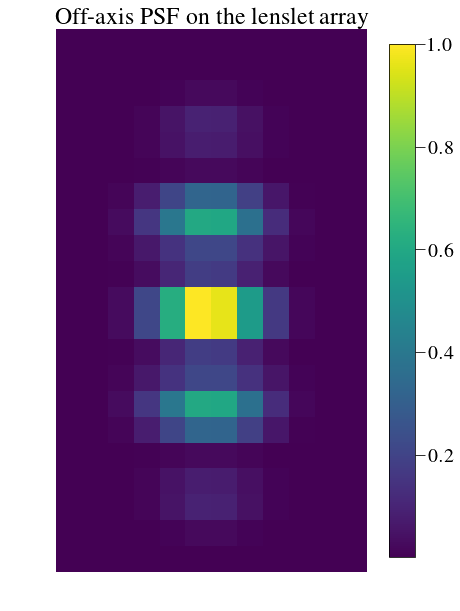

In [5]:
from astropy.io import fits
rotatedPSF = fits.getdata(par.exportDir+'/imagePlaneRot.fits')
plt.figure(figsize=(10,10))
fig = rotatedPSF[25,26:47,44:56]
fig /= np.amax(fig)
plt.imshow(fig)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Off-axis PSF on the lenslet array')


crispy - INFO - There is a maximum difference of 41.0% of the total flux between neighboring lenslets


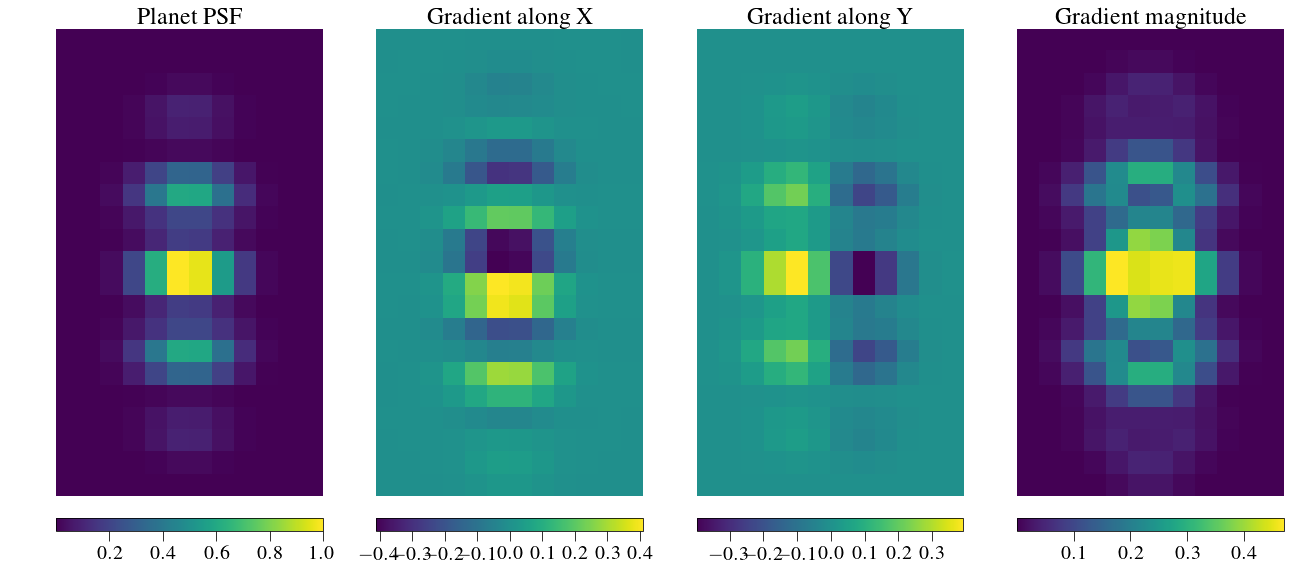

In [6]:
from scipy import ndimage
gx, gy = np.gradient(fig)
plt.figure(figsize=(22,10))
plt.subplot(144)
plt.imshow(np.hypot(gx,gy))
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')
plt.axis('off')
plt.title('Gradient magnitude')
plt.subplot(141)
plt.imshow(fig)
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')
plt.axis('off')
plt.title('Planet PSF')

plt.subplot(142)
plt.imshow(gx)
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')
plt.axis('off')
plt.title('Gradient along X')
plt.subplot(143)
plt.imshow(gy)
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')
plt.axis('off')
plt.title('Gradient along Y')

plt.savefig('/Users/mrizzo/Downloads/PSF_gradients.jpg')
log.info('There is a maximum difference of %.1f%% of the total flux between neighboring lenslets' % (100*max(np.amax(gx),np.amax(gy))))

## Now load new lenslets

In [7]:
import codecs

fname = '/Users/mrizzo/Downloads/right.txt'
readFile = codecs.open(fname,encoding='utf-16-le')
right=np.loadtxt(readFile,skiprows=18)
fname = '/Users/mrizzo/Downloads/center.txt'
readFile = codecs.open(fname,encoding='utf-16-le')
center=np.loadtxt(readFile,skiprows=18)
fname = '/Users/mrizzo/Downloads/left.txt'
readFile = codecs.open(fname,encoding='utf-16-le')
left=np.loadtxt(readFile,skiprows=18)
left /= np.sum(left)
right /= np.sum(right)
center /= np.sum(center)

qianscale = 0.719  # um/pixel in qian's image
detscale = 13.   # um/pixel on detector
qiansize = 92.065 # size of image
pixshift = detscale/qianscale


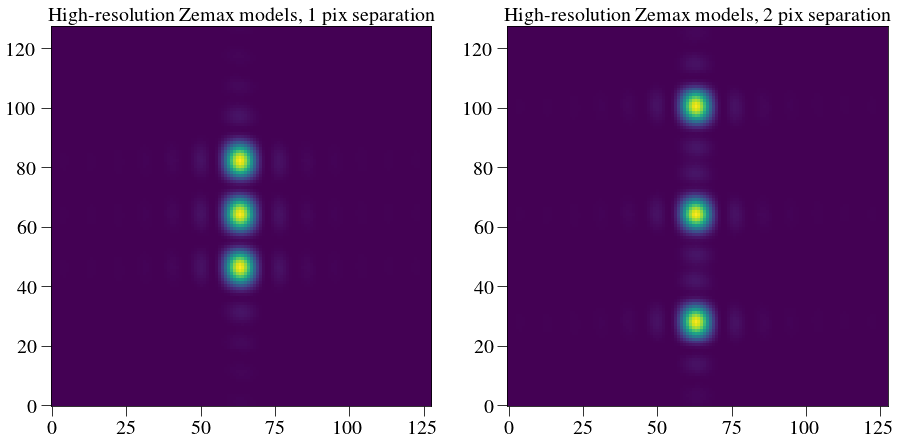

In [8]:
npxsep = 1
offset=0.0
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift+offset*pixshift,offset*pixshift],order=3)
center = ndimage.interpolation.shift(left,[offset*pixshift,offset*pixshift],order=3)
shiftleft = ndimage.interpolation.shift(right,[-npxsep*pixshift+offset*pixshift,offset*pixshift],order=3)
final = center+shiftright+shiftleft


plt.figure(figsize=(15,7))
plt.subplot(121)
npxsep = 1
plt.title('High-resolution Zemax models, %d pix separation' % npxsep,fontsize=20)
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift+offset*pixshift,offset*pixshift],order=3)
center = ndimage.interpolation.shift(left,[offset*pixshift,offset*pixshift],order=3)
shiftleft = ndimage.interpolation.shift(right,[-npxsep*pixshift+offset*pixshift,offset*pixshift],order=3)
final = center+shiftright+shiftleft
plt.imshow(final)
plt.subplot(122)
npxsep = 2
plt.title('High-resolution Zemax models, %d pix separation' % npxsep,fontsize=20)
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift+offset*pixshift,offset*pixshift],order=3)
center = ndimage.interpolation.shift(left,[offset*pixshift,offset*pixshift],order=3)
shiftleft = ndimage.interpolation.shift(right,[-npxsep*pixshift+offset*pixshift,offset*pixshift],order=3)
final = center+shiftright+shiftleft

plt.imshow(final)
plt.savefig('/Users/mrizzo/Downloads/overview.jpg',dpi=100)


## Construct microspectrum

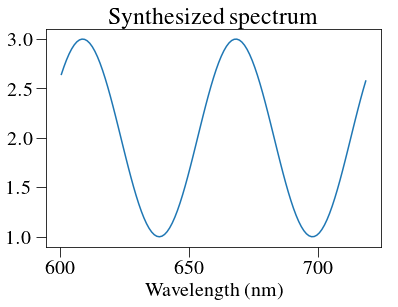

In [9]:
from scipy import interpolate
ncycles=2
dlam = 1 #nm
finlamlist = np.arange(min(lamlist),max(lamlist),dlam)
spectrum = np.sin(finlamlist/660.*2*np.pi*ncycles/par.BW)+2
plt.plot(finlamlist,spectrum)
plt.title('Synthesized spectrum')
plt.xlabel('Wavelength (nm)')

## Weights between the three lenslets

In [10]:
leftw = 1.0
centerw=0.6
rightw=0.2

## construct microspectra of 3 lenslets with random X, Y offset

In [11]:
# create large array
microspectrum = np.zeros((left.shape[0],500))
npixperdlam = 2.
R = 50.
startx = npixperdlam*R*np.log(min(lamlist)/660.)*pixshift


npxsep = 1
offsetx=np.random.rand()-0.5
offsety=np.random.rand()-0.5
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift+offsety*pixshift,offsetx*pixshift],order=3)
shiftcenter = ndimage.interpolation.shift(left,[offsety*pixshift,offsetx*pixshift],order=3)
shiftleft = ndimage.interpolation.shift(left,[-npxsep*pixshift+offsety*pixshift,offsetx*pixshift],order=3)
tright = np.zeros_like(microspectrum)
tright[:,:shiftright.shape[1]] = shiftright
tleft = np.zeros_like(microspectrum)
tleft[:,:shiftleft.shape[1]] = shiftleft
tcenter = np.zeros_like(microspectrum)
tcenter[:,:shiftcenter.shape[1]] = shiftcenter

for i, lam in enumerate(finlamlist):
    dispersion = npixperdlam*R*np.log(lam/660.)
    microspectrum += spectrum[i]*leftw*ndimage.interpolation.shift(tleft,[0.0,dispersion*pixshift-startx],order=3)*dlam
    microspectrum += spectrum[i]*centerw*ndimage.interpolation.shift(tcenter,[0.0,dispersion*pixshift-startx],order=3)*dlam
    microspectrum += spectrum[i]*rightw*ndimage.interpolation.shift(tright,[0.0,dispersion*pixshift-startx],order=3)*dlam

# microspectrum = microspectrum[:,35:-75]


crispy - INFO - 425.263803183
crispy - INFO - 425.263803183


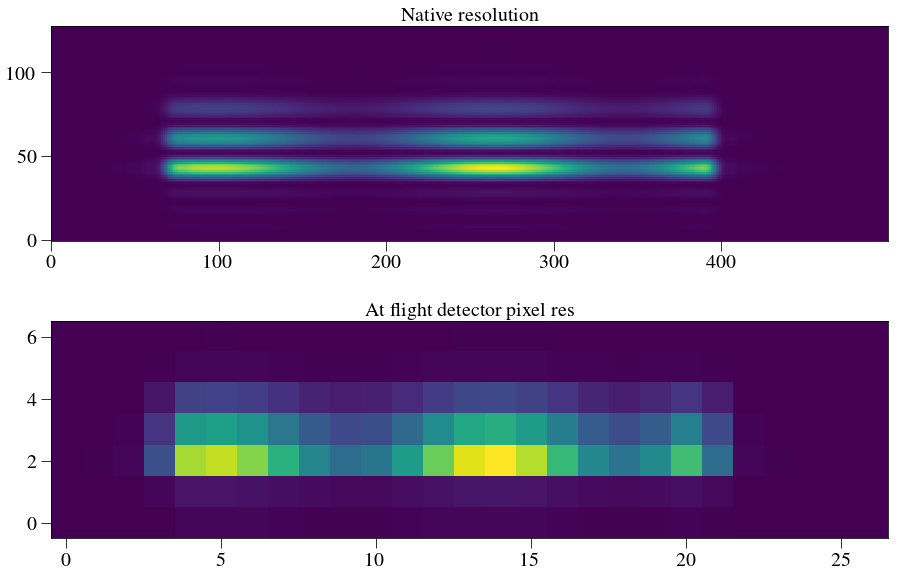

In [12]:

rebinned = frebin(microspectrum,(int(microspectrum.shape[1]/pixshift),int(microspectrum.shape[0]/pixshift)))
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.imshow(microspectrum)
plt.title('Native resolution',fontsize=20)
plt.subplot(212)
plt.imshow(rebinned)
plt.title('At flight detector pixel res',fontsize=20)
log.info(np.sum(microspectrum))
log.info(np.sum(rebinned))

## Practice least-squares extraction with single group of 3 spectra

We will construct slightly smoothed template PSFLets just like in cripy/CHARIS DRP. The idea is to simultaneously least square the three microspectra at once. Note that for the moment, all the PSFLets are the same and do not change as a function of wavelength.

In [13]:
# least square resolution:
nchanperspec_lstsq = 1.2
nlam = 20
Nspec = int(np.log(max(lamlist)/min(lamlist))*R*nchanperspec_lstsq+2)
loglam_endpts = np.linspace(np.log(min(lamlist)), np.log(max(lamlist)), Nspec)
loglam_midpts = (loglam_endpts[1:] + loglam_endpts[:-1])/2
lam_endpts = np.exp(loglam_endpts)
lam_midpts = np.exp(loglam_midpts)

# hiresrebin = frebin(microspectrum,(int(microspectrum.shape[1]/calibpixshift),int(microspectrum.shape[0]/calibpixshift)))
# ysize,xsize = hiresrebin.shape
# plt.figure(figsize=(15,10))
# plt.imshow(hiresrebin)


## First we need to build a fake polychrome

In [14]:
ysize,xsize = rebinned.shape
polyimage = np.zeros(((Nspec - 1)*3, ysize, xsize))
for i in range(Nspec - 1):
    
    dloglam = (np.log(lam_endpts[i + 1]) - np.log(lam_endpts[i]))/nlam
    loglam = np.log(lam_endpts[i]) + dloglam/2. + np.arange(nlam)*dloglam
    for n,lam in enumerate(np.exp(loglam)):
        dispersion = npixperdlam*R*np.log(lam/660.)
        tmp = ndimage.interpolation.shift(tleft,[0.0,dispersion*pixshift-startx],order=3)
        polyimage[i] += frebin(tmp,polyimage[i].T.shape)
        tmp = ndimage.interpolation.shift(tcenter,[0.0,dispersion*pixshift-startx],order=3)
        polyimage[i+(Nspec - 1)] += frebin(tmp,polyimage[i].T.shape)
        tmp = ndimage.interpolation.shift(tright,[0.0,dispersion*pixshift-startx],order=3)
        polyimage[i+2*(Nspec - 1)] += frebin(tmp,polyimage[i].T.shape)
    polyimage[i] /= np.sum(polyimage[i])
    polyimage[i+(Nspec - 1)] /= np.sum(polyimage[i+(Nspec - 1)])
    polyimage[i+2*(Nspec - 1)] /= np.sum(polyimage[i+2*(Nspec - 1)])



## Here is the least squares fit

In [15]:
img_flat = np.reshape(rebinned, -1)
psflets_flat = np.reshape(polyimage, (polyimage.shape[0], -1))
coef = np.linalg.lstsq(psflets_flat.T, img_flat)[0]

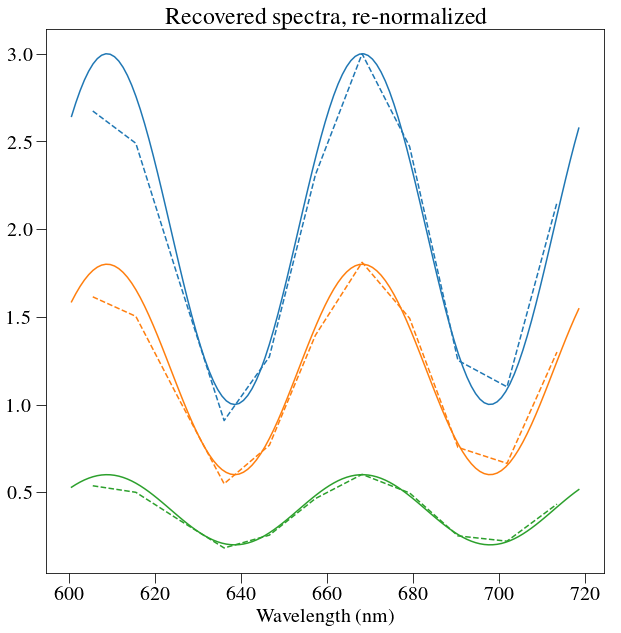

In [16]:
plt.figure(figsize=(10,10))
plt.plot(lam_midpts,coef[:(Nspec - 1)]/np.amax(coef)*np.amax(spectrum),'C0',ls='--')
plt.plot(finlamlist,spectrum*leftw,'C0')

plt.plot(lam_midpts,coef[(Nspec - 1):2*(Nspec - 1)]/np.amax(coef)*np.amax(spectrum),'C1',ls='--')
plt.plot(finlamlist,spectrum*centerw,'C1')

plt.plot(lam_midpts,coef[2*(Nspec - 1):]/np.amax(coef)*np.amax(spectrum),'C2',ls='--')
plt.plot(finlamlist,spectrum*rightw,'C2')
plt.title('Recovered spectra, re-normalized')
plt.xlabel('Wavelength (nm)')

## Reconstruct the microspectra

In [17]:
model = np.zeros_like(rebinned)
for i in range(polyimage.shape[0]):
    model += polyimage[i]*coef[i]
residuals = rebinned-model
old_frac_error = 100*np.sum(residuals)/np.sum(rebinned)
old_rms_error = 100*np.std(residuals)/np.amax(rebinned)
log.info('Fractional error is %.2f%% of the flux' % old_frac_error)
log.info('rms normalized to max is %.2f%%' % old_rms_error)


crispy - INFO - Fractional error is 0.39% of the flux
crispy - INFO - rms normalized to max is 0.94%


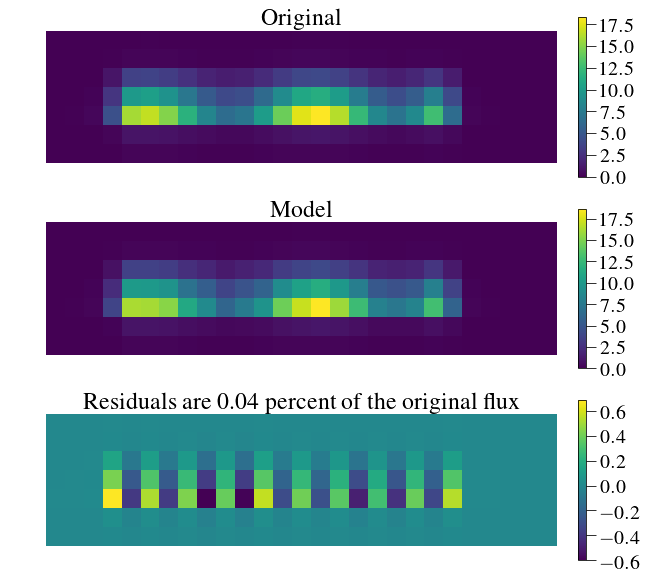

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(rebinned)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Original')
plt.subplot(312)
plt.imshow(model)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Model')
plt.subplot(313)
plt.imshow(residuals)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Residuals are %.2f percent of the original flux' % (100*np.sum(residuals)/np.sum(rebinned)))


## Now repeat but with a knowledge of the PSFLets only to within 2um pixels

crispy - INFO - 2.78164116829
crispy - INFO - Fractional error is -0.14% of the flux
crispy - INFO - rms normalized to max is 1.00%


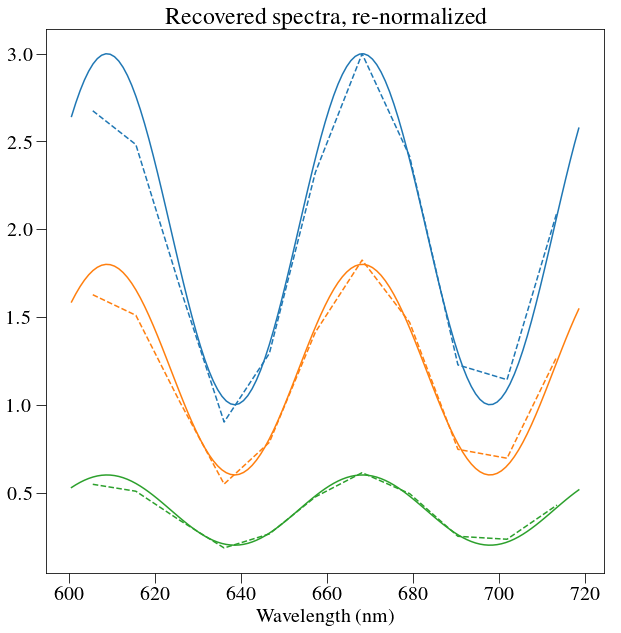

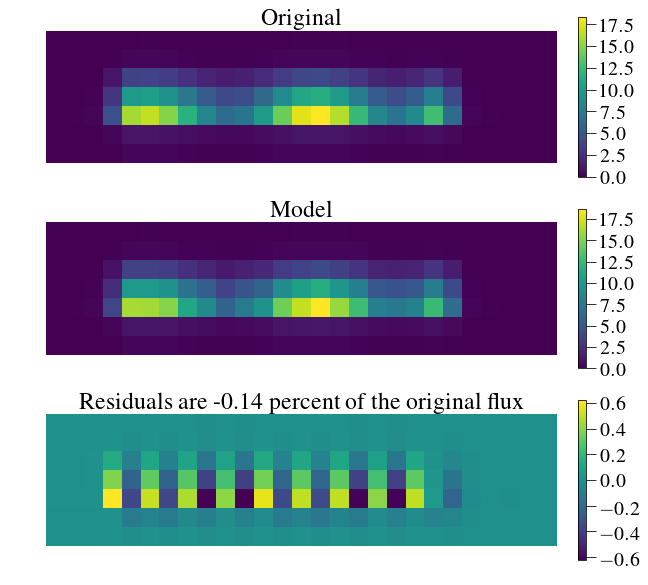

In [19]:
calibscale = 2 #pixel size of calibration detector in um
calibpixshift = calibscale/qianscale
log.info(calibpixshift)

tleft_calib = frebin(tleft,
                        (int(microspectrum.shape[1]/calibpixshift),int(microspectrum.shape[0]/calibpixshift)))
tcenter_calib = frebin(tcenter,tleft_calib.T.shape)
tright_calib = frebin(tright,tleft_calib.T.shape)
# plt.figure(figsize=(15,10))
# plt.imshow(tcenter_calib)
# plt.title('Calibration PSFLet')

startx = npixperdlam*R*np.log(min(lamlist)/660.)*pixshift/calibpixshift

ysize,xsize = rebinned.shape
polyimage = np.zeros(((Nspec - 1)*3, ysize, xsize))
for i in range(Nspec - 1):
    
    dloglam = (np.log(lam_endpts[i + 1]) - np.log(lam_endpts[i]))/nlam
    loglam = np.log(lam_endpts[i]) + dloglam/2. + np.arange(nlam)*dloglam
    for n,lam in enumerate(np.exp(loglam)):
        dispersion = npixperdlam*R*np.log(lam/660.)
        # note that now we are shifting the images that are not as well resolved
        tmp = ndimage.interpolation.shift(tleft_calib,[0.0,dispersion*pixshift/calibpixshift-startx],order=3)
        polyimage[i] += frebin(tmp,polyimage[i].T.shape)
        tmp = ndimage.interpolation.shift(tcenter_calib,[0.0,dispersion*pixshift/calibpixshift-startx],order=3)
        polyimage[i+(Nspec - 1)] += frebin(tmp,polyimage[i].T.shape)
        tmp = ndimage.interpolation.shift(tright_calib,[0.0,dispersion*pixshift/calibpixshift-startx],order=3)
        polyimage[i+2*(Nspec - 1)] += frebin(tmp,polyimage[i].T.shape)
    polyimage[i] /= np.sum(polyimage[i])
    polyimage[i+(Nspec - 1)] /= np.sum(polyimage[i+(Nspec - 1)])
    polyimage[i+2*(Nspec - 1)] /= np.sum(polyimage[i+2*(Nspec - 1)])

# plt.figure(figsize=(15,10))
# plt.imshow(polyimage[Nspec+1])

img_flat = np.reshape(rebinned, -1)
psflets_flat = np.reshape(polyimage, (polyimage.shape[0], -1))
coef = np.linalg.lstsq(psflets_flat.T, img_flat)[0]

plt.figure(figsize=(10,10))
plt.plot(lam_midpts,coef[:(Nspec - 1)]/np.amax(coef)*np.amax(spectrum),'C0',ls='--')
plt.plot(finlamlist,spectrum*leftw,'C0')

plt.plot(lam_midpts,coef[(Nspec - 1):2*(Nspec - 1)]/np.amax(coef)*np.amax(spectrum),'C1',ls='--')
plt.plot(finlamlist,spectrum*centerw,'C1')

plt.plot(lam_midpts,coef[2*(Nspec - 1):]/np.amax(coef)*np.amax(spectrum),'C2',ls='--')
plt.plot(finlamlist,spectrum*rightw,'C2')
plt.title('Recovered spectra, re-normalized')
plt.xlabel('Wavelength (nm)')

model = np.zeros_like(rebinned)
for i in range(polyimage.shape[0]):
    model += polyimage[i]*coef[i]
residuals = rebinned-model
log.info('Fractional error is %.2f%% of the flux' % (100*np.sum(residuals)/np.sum(rebinned)))
log.info('rms normalized to max is %.2f%%' % (100*np.std(residuals)/np.amax(rebinned)))


plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(rebinned)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Original')
plt.subplot(312)
plt.imshow(model)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Model')
plt.subplot(313)
plt.imshow(residuals)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Residuals are %.2f percent of the original flux' % (100*np.sum(residuals)/np.sum(rebinned)))

# Now, is it possible to centroid that spectrum?

Let's start with centroiding a monochromatic trio of PSFs

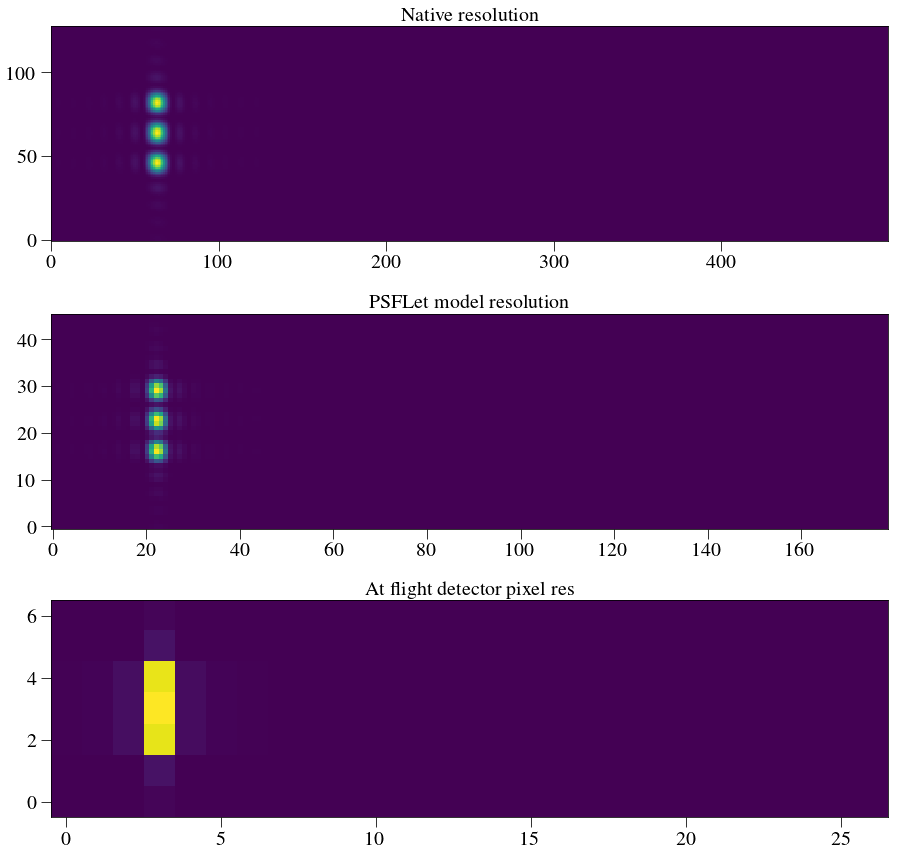

In [20]:
# create large array
startx = npixperdlam*R*np.log(min(lamlist)/660.)*pixshift


npxsep = 1
# offsetx=np.random.rand()-0.5
# offsety=np.random.rand()-0.5
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift,0.0],order=3)
shiftcenter = ndimage.interpolation.shift(left,[0.0,0.0],order=3)
shiftleft = ndimage.interpolation.shift(left,[-npxsep*pixshift,0.0],order=3)
tright = np.zeros_like(microspectrum)
tright[:,:shiftright.shape[1]] = shiftright
tleft = np.zeros_like(microspectrum)
tleft[:,:shiftleft.shape[1]] = shiftleft
tcenter = np.zeros_like(microspectrum)
tcenter[:,:shiftcenter.shape[1]] = shiftcenter
model = tright+tcenter+tleft
# model_rebin = frebin(model,
#                         (int(model.shape[1]/pixshift),int(model.shape[0]/pixshift)))
model_rebin_calib = frebin(model,
                        (int(model.shape[1]/calibpixshift),int(model.shape[0]/calibpixshift)))
model_rebin = frebin(model_rebin_calib,
                        (int(model.shape[1]/pixshift),int(model.shape[0]/pixshift)))

plt.figure(figsize=(15,15))
plt.subplot(311)
plt.imshow(model)
plt.title('Native resolution',fontsize=20)
plt.subplot(312)
plt.imshow(model_rebin_calib)
plt.title('PSFLet model resolution',fontsize=20)
plt.subplot(313)
plt.imshow(model_rebin)
plt.title('At flight detector pixel res',fontsize=20)


## Construct the offset PSF

crispy - INFO - Offsets: 0.39,-0.17


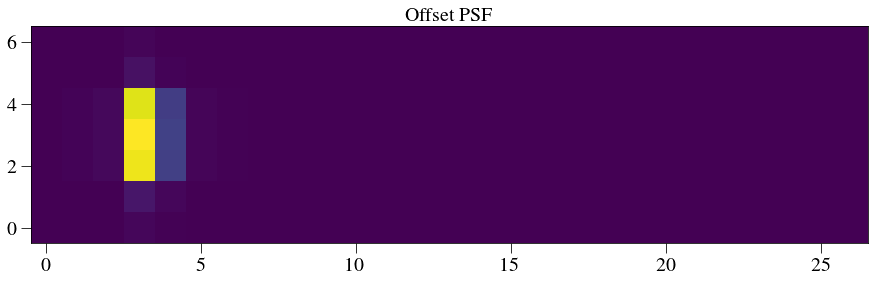

In [21]:
log.info('Offsets: %.2f,%.2f' %(offsetx,offsety))
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift+offsety*pixshift,offsetx*pixshift],order=3)
shiftcenter = ndimage.interpolation.shift(left,[offsety*pixshift,offsetx*pixshift],order=3)
shiftleft = ndimage.interpolation.shift(left,[-npxsep*pixshift+offsety*pixshift,offsetx*pixshift],order=3)
tright = np.zeros_like(microspectrum)
tright[:,:shiftright.shape[1]] = shiftright
tleft = np.zeros_like(microspectrum)
tleft[:,:shiftleft.shape[1]] = shiftleft
tcenter = np.zeros_like(microspectrum)
tcenter[:,:shiftcenter.shape[1]] = shiftcenter
meas = tright+tcenter+tleft
meas_rebin = frebin(meas,
                        (int(meas.shape[1]/pixshift),int(meas.shape[0]/pixshift)))
meas_rebin_calib = frebin(meas,
                        (int(meas.shape[1]/calibpixshift),int(meas.shape[0]/calibpixshift)))

plt.figure(figsize=(15,10))
plt.imshow(meas_rebin)
plt.title('Offset PSF',fontsize=20)


## Attempt reconstructing the offset using a curve_fit

In [22]:
scale = pixshift/calibpixshift
def model_func(i, offx,offy):
    shifted = ndimage.interpolation.shift(model_rebin_calib,[offy*scale,offx*scale],order=3)
    return np.reshape(frebin(shifted,model_rebin.T.shape),-1)[i]


In [23]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(model_func, np.arange(len(np.reshape(model_rebin,-1))), np.reshape(meas_rebin,-1), p0=[0.5,0.5])
log.info('Real Offsets: %.2f,%.2f' %(offsetx,offsety))
log.info('Fitted Offsets: %.2f,%.2f' % (popt[0],popt[1]))

crispy - INFO - Real Offsets: 0.39,-0.17
crispy - INFO - Fitted Offsets: 0.37,-0.14


## Attempt using a brute-force grid search followed by a 2D minimum search

crispy - INFO - Real Offsets: 0.39,-0.17
crispy - INFO - Fitted offsets: 0.36, -0.16
crispy - INFO - We can do even a bit better with interpolating the grid


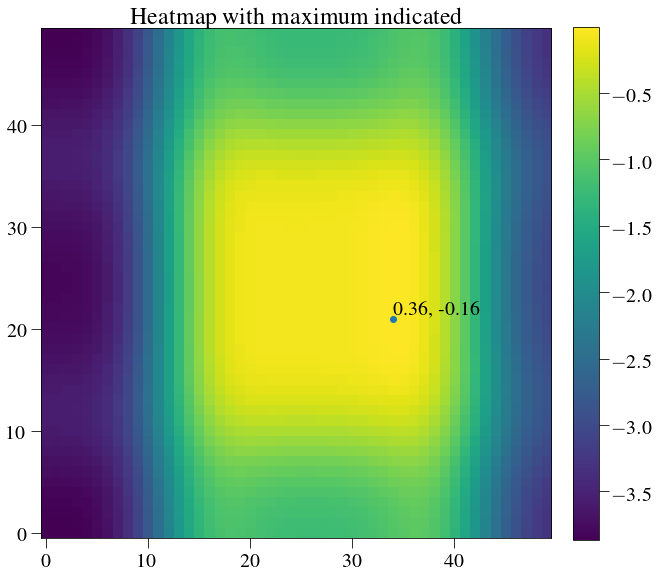

In [24]:
def model_func2d(offx,offy):
    shifted = ndimage.interpolation.shift(model_rebin_calib,[offy*scale,offx*scale],order=3)
    return frebin(shifted,model_rebin.T.shape)

npix = 2
nx = 50
ny = 50
grid = np.zeros((nx,ny))
yoffsets,xoffsets = np.meshgrid(npix*np.arange(-nx//2,nx//2)/float(nx),npix*np.arange(-ny//2,ny//2)/float(ny))
for ox in range(nx):
    for oy in range(ny):
        grid[oy,ox] = np.sum((model_func2d(xoffsets[ox,oy],yoffsets[ox,oy])-meas_rebin)**2)

coords = np.unravel_index(grid.argmin(), grid.shape)
log.info('Real Offsets: %.2f,%.2f' %(offsetx,offsety))
log.info('Fitted offsets: %.2f, %.2f' % (yoffsets[coords],xoffsets[coords]))
plt.figure(figsize=(10,10))
plt.imshow(-grid)
plt.title('Heatmap with maximum indicated')
plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter([coords[1]],[coords[0]])
plt.annotate('%.2f, %.2f' % (yoffsets[coords],xoffsets[coords]),xy=coords[::-1],ha='left',va='bottom')
log.info('We can do even a bit better with interpolating the grid')

## Fit the centroid of the entire microspectrum

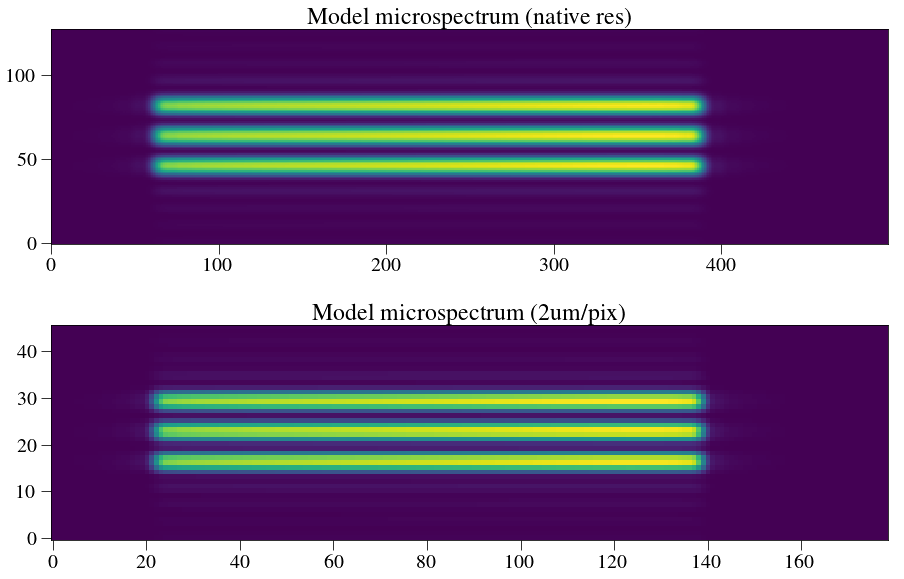

In [25]:
# create large array
microspectrum = np.zeros((left.shape[0],500))
npixperdlam = 2.
R = 50.
startx = npixperdlam*R*np.log(min(lamlist)/660.)*pixshift


npxsep = 1
# offsetx=np.random.rand()-0.5
# offsety=np.random.rand()-0.5
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift,0.0],order=3)
shiftcenter = ndimage.interpolation.shift(left,[0.0,0.0],order=3)
shiftleft = ndimage.interpolation.shift(left,[-npxsep*pixshift,0.0],order=3)
tright = np.zeros_like(microspectrum)
tright[:,:shiftright.shape[1]] = shiftright
tleft = np.zeros_like(microspectrum)
tleft[:,:shiftleft.shape[1]] = shiftleft
tcenter = np.zeros_like(microspectrum)
tcenter[:,:shiftcenter.shape[1]] = shiftcenter

for i, lam in enumerate(finlamlist):
    dispersion = npixperdlam*R*np.log(lam/660.)
    microspectrum += ndimage.interpolation.shift(tleft,[0.0,dispersion*pixshift-startx],order=3)*dlam
    microspectrum += ndimage.interpolation.shift(tcenter,[0.0,dispersion*pixshift-startx],order=3)*dlam
    microspectrum += ndimage.interpolation.shift(tright,[0.0,dispersion*pixshift-startx],order=3)*dlam

# microspectrum = microspectrum[:,35:-75]
model_microspectrum_calib = frebin(microspectrum,model_rebin_calib.T.shape)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.imshow(microspectrum)
plt.title('Model microspectrum (native res)')
plt.subplot(212)
plt.imshow(model_microspectrum_calib)
plt.title('Model microspectrum (2um/pix)')


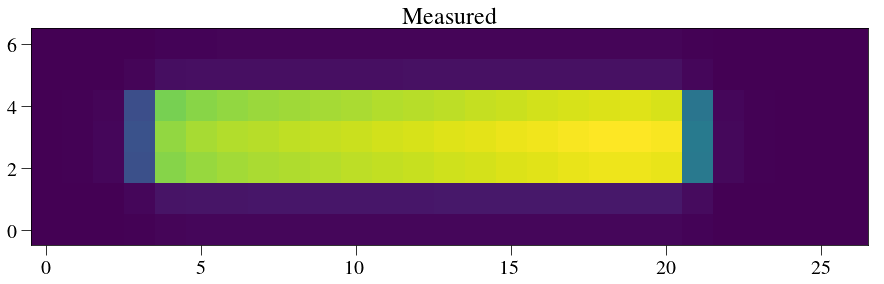

In [26]:
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift+offsety*pixshift,offsetx*pixshift],order=3)
shiftcenter = ndimage.interpolation.shift(left,[offsety*pixshift,offsetx*pixshift],order=3)
shiftleft = ndimage.interpolation.shift(left,[-npxsep*pixshift+offsety*pixshift,offsetx*pixshift],order=3)
tright = np.zeros_like(microspectrum)
tright[:,:shiftright.shape[1]] = shiftright
tleft = np.zeros_like(microspectrum)
tleft[:,:shiftleft.shape[1]] = shiftleft
tcenter = np.zeros_like(microspectrum)
tcenter[:,:shiftcenter.shape[1]] = shiftcenter

micro_meas = np.zeros_like(microspectrum)
for i, lam in enumerate(finlamlist):
    dispersion = npixperdlam*R*np.log(lam/660.)
    micro_meas += ndimage.interpolation.shift(tleft,[0.0,dispersion*pixshift-startx],order=3)*dlam
    micro_meas += ndimage.interpolation.shift(tcenter,[0.0,dispersion*pixshift-startx],order=3)*dlam
    micro_meas += ndimage.interpolation.shift(tright,[0.0,dispersion*pixshift-startx],order=3)*dlam

micro_meas_rebin = frebin(micro_meas,
                        (int(micro_meas.shape[1]/pixshift),int(micro_meas.shape[0]/pixshift)))
micro_meas_rebin_calib = frebin(micro_meas,
                        (int(micro_meas.shape[1]/calibpixshift),int(micro_meas.shape[0]/calibpixshift)))

plt.figure(figsize=(15,10))
plt.imshow(micro_meas_rebin)
plt.title('Measured')


## Brute force grid search

crispy - INFO - Real Offsets: 0.39,-0.17
crispy - INFO - Fitted offsets: 0.38, -0.14
crispy - INFO - We can do even a bit better with interpolating the grid


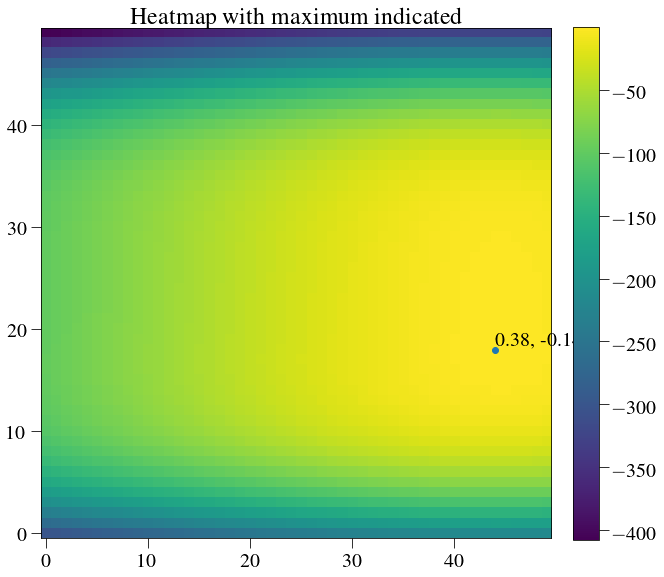

In [28]:
def model_func2d_micro(offx,offy):
    shifted = ndimage.interpolation.shift(model_microspectrum_calib,[offy*scale,offx*scale],order=3)
    return frebin(shifted,micro_meas_rebin.T.shape)

npix = 1
nx = 50
ny = 50
grid = np.zeros((nx,ny))
yoffsets,xoffsets = np.meshgrid(npix*np.arange(-nx//2,nx//2)/float(nx),npix*np.arange(-ny//2,ny//2)/float(ny))
for ox in range(nx):
    for oy in range(ny):
        grid[oy,ox] = np.sum((model_func2d_micro(xoffsets[ox,oy],yoffsets[ox,oy])-micro_meas_rebin)**2)

coords = np.unravel_index(grid.argmin(), grid.shape)
log.info('Real Offsets: %.2f,%.2f' %(offsetx,offsety))
log.info('Fitted offsets: %.2f, %.2f' % (yoffsets[coords],xoffsets[coords]))
plt.figure(figsize=(10,10))
plt.imshow(-grid)
plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter([coords[1]],[coords[0]])
plt.annotate('%.2f, %.2f' % (yoffsets[coords],xoffsets[coords]),xy=coords[::-1],ha='left',va='bottom')
plt.title('Heatmap with maximum indicated')
log.info('We can do even a bit better with interpolating the grid')

## Do this with noise?

This is a bit more involved: find representative photon fluxes, add in detector noise, and try to see if the least squares works...

## Next step: show multiple spectra on the detector

Come up with a simple geometric relation to place the spectra on detector

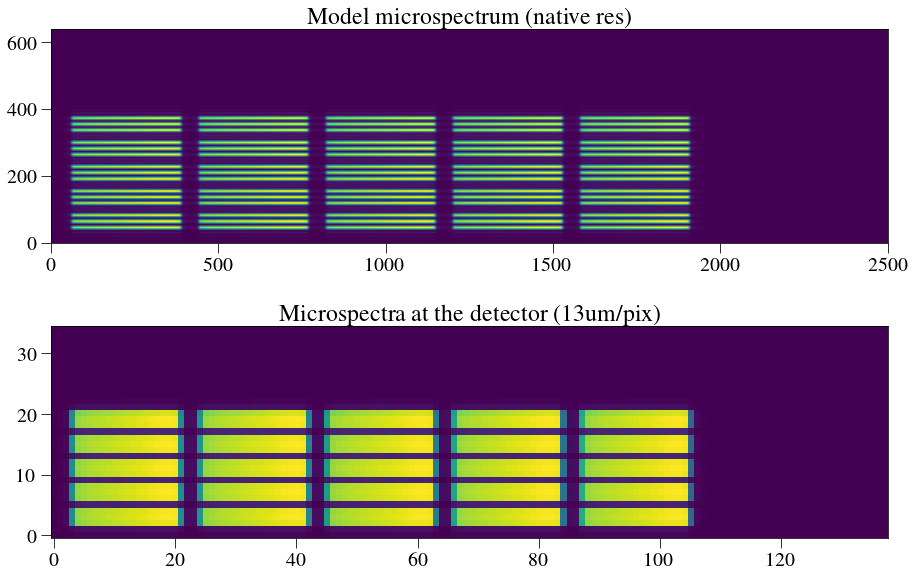

In [41]:
nspec = 5
ncol = 5
dist_btw_groups = 1
vshift = 3
hshift=19
dist_btw_col = 2
microspectrum = np.zeros((left.shape[0]*nspec,500*ncol))
npixperdlam = 2.
R = 50.
startx = npixperdlam*R*np.log(min(lamlist)/660.)*pixshift
from scipy.ndimage.interpolation import shift

npxsep = 1
# offsetx=np.random.rand()-0.5
# offsety=np.random.rand()-0.5
shiftright = ndimage.interpolation.shift(left,[npxsep*pixshift,0.0],order=3)
shiftcenter = ndimage.interpolation.shift(left,[0.0,0.0],order=3)
shiftleft = ndimage.interpolation.shift(left,[-npxsep*pixshift,0.0],order=3)
tright = np.zeros_like(microspectrum)
tright[:shiftright.shape[0],:shiftright.shape[1]] = shiftright
tleft = np.zeros_like(microspectrum)
tleft[:shiftright.shape[0],:shiftright.shape[1]] = shiftleft
tcenter = np.zeros_like(microspectrum)
tcenter[:shiftright.shape[0],:shiftright.shape[1]] = shiftcenter

tright = ndimage.spline_filter(tright)
tcenter = ndimage.spline_filter(tcenter)
tleft = ndimage.spline_filter(tleft)

for xshift in range(ncol):
    for yshift in range(nspec):
        for i, lam in enumerate(finlamlist):
            dispersion = npixperdlam*R*np.log(lam/660.)
            microspectrum += shift(tleft,
                                    [yshift*(vshift*pixshift+dist_btw_groups*pixshift),
                                    dispersion*pixshift-startx+xshift*(hshift+dist_btw_col)*pixshift],
                                    order=3,prefilter=False)*dlam
            microspectrum += shift(tcenter,
                                    [yshift*(vshift*pixshift+dist_btw_groups*pixshift),
                                    dispersion*pixshift-startx+xshift*(hshift+dist_btw_col)*pixshift],
                                    order=3,prefilter=False)*dlam
            microspectrum += shift(tright,
                                    [yshift*(vshift*pixshift+dist_btw_groups*pixshift),
                                    dispersion*pixshift-startx+xshift*(hshift+dist_btw_col)*pixshift],
                                    order=3,prefilter=False)*dlam

# microspectrum = microspectrum[:,35:-75]
microspectrum_rebin = frebin(microspectrum,
                        (int(microspectrum.shape[1]/pixshift),int(microspectrum.shape[0]/pixshift)))
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.imshow(microspectrum)
plt.title('Model microspectrum (native res)')
plt.subplot(212)
plt.imshow(microspectrum_rebin)
plt.title('Microspectra at the detector (13um/pix)')
